# 05: Training the ML algorithm

In [5]:
import SMEFT19
import pandas as pd
import shap
import numpy as np

In [2]:
d = SMEFT19.ellipse.load('../data/ellipses/rotBII.yaml')

In [3]:
ML = SMEFT19.ml.train(['../data/samples/randompoints.dat', '../data/samples/samplealbl.dat', '../data/samples/sampleaqbq.dat'],
                 '../data/samples/validationpoints.dat', '../data/MLmodels/xgb_lh.json', d['bf'], headers=0)

[0]	validation_0-rmse:16.98649
[1]	validation_0-rmse:16.14512
[2]	validation_0-rmse:15.34632
[3]	validation_0-rmse:14.58630
[4]	validation_0-rmse:13.86495
[5]	validation_0-rmse:13.18359
[6]	validation_0-rmse:12.53318
[7]	validation_0-rmse:11.91543
[8]	validation_0-rmse:11.33209
[9]	validation_0-rmse:10.77519
[10]	validation_0-rmse:10.24900
[11]	validation_0-rmse:9.74801
[12]	validation_0-rmse:9.27141
[13]	validation_0-rmse:8.82152
[14]	validation_0-rmse:8.39332
[15]	validation_0-rmse:7.98826
[16]	validation_0-rmse:7.60256
[17]	validation_0-rmse:7.23791
[18]	validation_0-rmse:6.89156
[19]	validation_0-rmse:6.56353
[20]	validation_0-rmse:6.25165
[21]	validation_0-rmse:5.95653
[22]	validation_0-rmse:5.67544
[23]	validation_0-rmse:5.40947
[24]	validation_0-rmse:5.15703
[25]	validation_0-rmse:4.91576
[26]	validation_0-rmse:4.68918
[27]	validation_0-rmse:4.47526
[28]	validation_0-rmse:4.27170
[29]	validation_0-rmse:4.07833
[30]	validation_0-rmse:3.89710
[31]	validation_0-rmse:3.72504
[32]	va

## Linear regression

Here we check that the ML approximation correctly reproduces the likelihood of the datapoints

In [4]:
ML = SMEFT19.ml.load_model('../data/MLmodels/xgb_lh.json', '../data/samples/validationpoints.dat', d['bf'])
ML.featurenames = ['C', 'al', 'bl', 'aq', 'bq']

PearsonRResult(statistic=0.9776101389536795, pvalue=0.0)

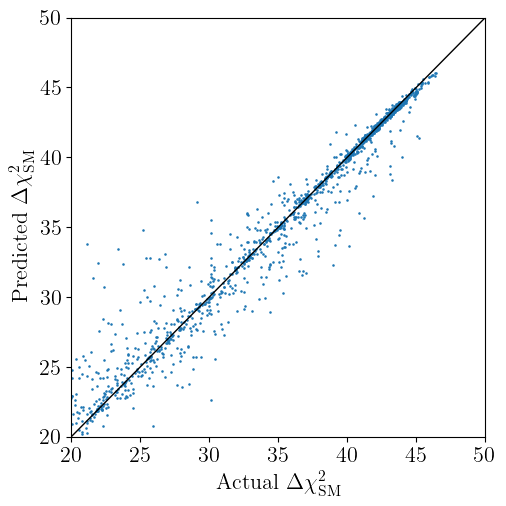

In [5]:
SMEFT19.ml.regr(ML, '../data/samples/validationpoints.dat', '../data/plots/regression_xgb')

## Distribution

Now we generate a small sample of points with a Montecarlo algorithm using the ML-approximation of the likelihood

In [6]:
newpoints = ML.newpoints(500)
df = pd.DataFrame(newpoints, columns=['C', 'al', 'bl', 'aq', 'bq'])
preds = ML.model.predict(df)

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

And compare the resulting histogram with the p.d.f of a $\chi^2$ distribution with 5 degrees of freedom

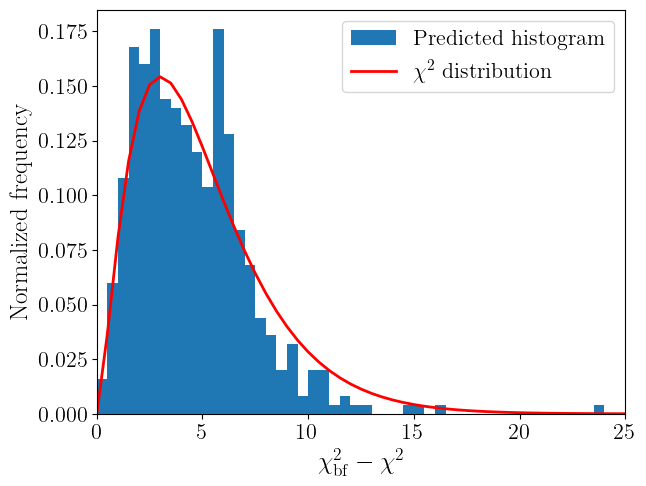

In [9]:
_ = plt.hist(2*max(preds) - 2*preds, bins=50, range=(0,25), density=True, label='Predicted histogram')
plt.plot(np.linspace(0,25,51), chi2(5).pdf(np.linspace(0,25,51)), label=r'$\chi^2$ distribution', lw=2, c='r')
plt.xlim([0,25])
plt.xlabel(r'$\chi^2_\mathrm{bf} - \chi^2$', fontsize=18)
plt.ylabel('Normalized frequency', fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/hist_xgb.pdf')
plt.savefig('../data/plots/hist_xgb.pgf')

## SHAP

In [10]:
newpoints += ML.newpoints(500)

In [11]:
ML = SMEFT19.ml.load_model('../data/MLmodels/xgb_lh.json', '../data/samples/validationpoints.dat', d['bf'])
ML.featurenames = ['C', 'al', 'bl', 'aq', 'bq']

In [12]:
dfnewpoints = pd.DataFrame(newpoints, columns=['C', 'al', 'bl', 'aq', 'bq'])
dfnewpoints['logL'] = ML.model.predict(dfnewpoints)
dfnewpoints.to_csv('../data/samples/mlpoints.dat', sep='\t', index=False)

In [13]:
explainer = shap.TreeExplainer(ML.model)
print(f'Base value: {float(explainer.expected_value)}')
bfs = pd.DataFrame(data=d['bf'].reshape(1, 5), columns = ['$C$', '$\\alpha^\\ell$',
                                              '$\\beta^\\ell$', '$\\alpha^q$',
                                              '$\\beta^q$'] )
print(f'SHAP values: {explainer.shap_values(bfs)}')
total = float(explainer.expected_value)+np.sum(explainer.shap_values(bfs))
print(f'Total prediction: {total}')

Base value: 0.5
SHAP values: [[0.8984124 1.0841255 0.1545804 1.0430342 0.5202897]]
Total prediction: 21.911547422409058


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

def SHAP_summary2(fmodel, points, fout, header=None):
    r'''
Creates a summary plot of the average SHAP values on a dataset.

:Arguments:

    - fmodel\: Path to the file where the model was saved.
    - points\: Pandas Dataframe containing the dataset.
    - fout\: Path to save the plot (pdf only).
    - header\: If the data file contains headers in the first row, 0.
    '''

    model = XGBRegressor()
    model.load_model(fmodel)
    explainer = shap.TreeExplainer(model)
    df = pd.read_csv(points, sep='\t', names=['$C$', '$\\alpha^\\ell$',
                                              '$\\beta^\\ell$', '$\\alpha^q$',
                                              '$\\beta^q$', 'logL'], header=header)
    features = ['$C$', '$\\alpha^\\ell$', '$\\beta^\\ell$', '$\\alpha^q$', '$\\beta^q$']
    X = df[features]
    sv = explainer(X)
    #shap.plots.beeswarm(sv, color_bar=False, show=False)
    shap.plots.beeswarm(sv, show=False)
    plt.xticks(fontsize=16)
    #plt.tight_layout(pad=0.5)
    plt.savefig(fout+'.pdf')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


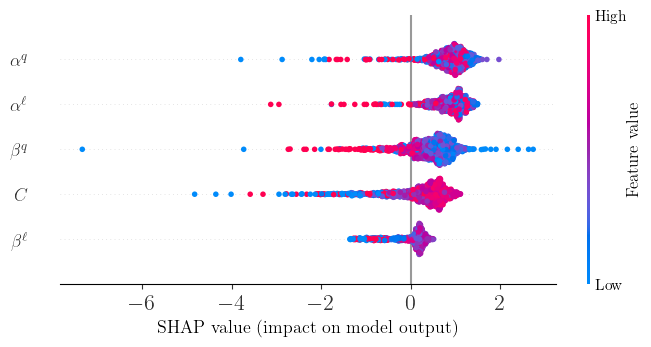

In [5]:
SHAP_summary2('../data/MLmodels/xgb_lh.json', '../data/samples/mlpoints.dat', '../data/plots/SHAP_summary', 0)

In [15]:
import matplotlib.pyplot as plt
import numpy as np

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


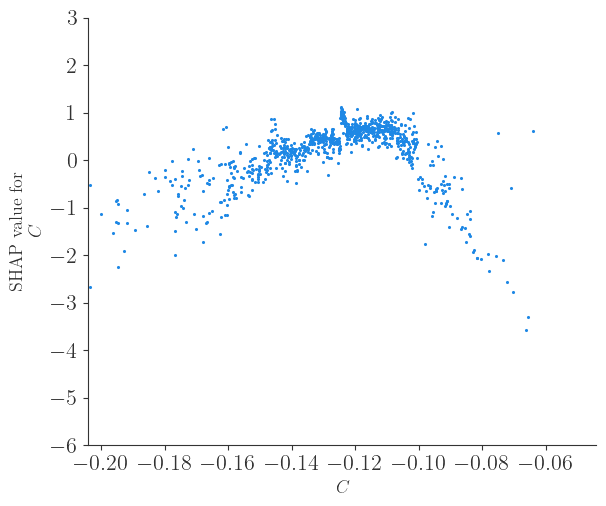

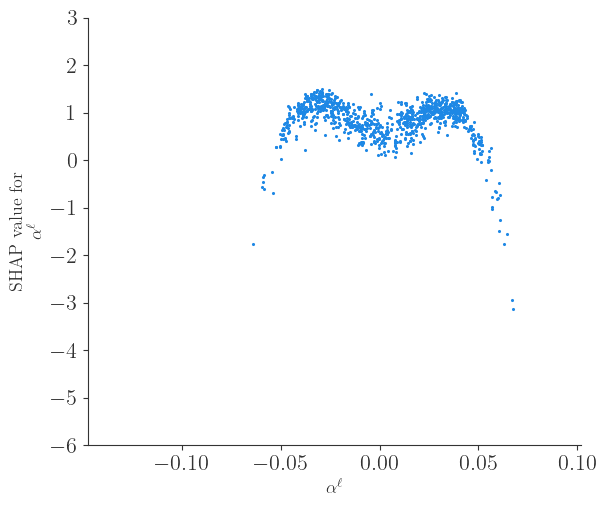

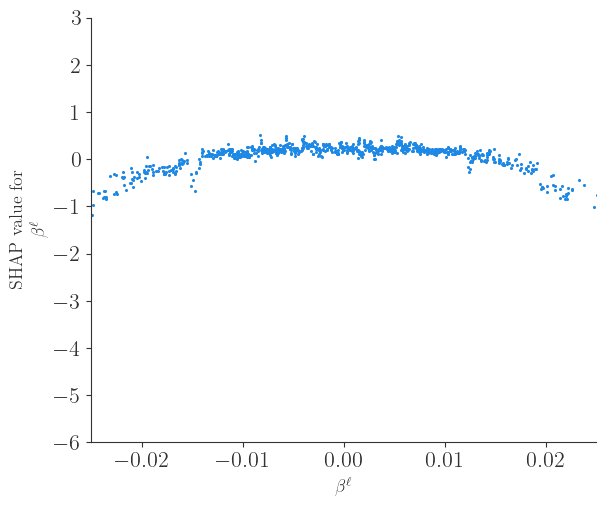

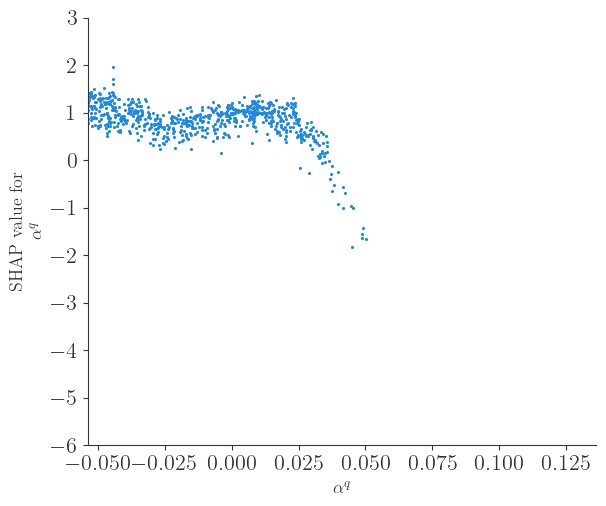

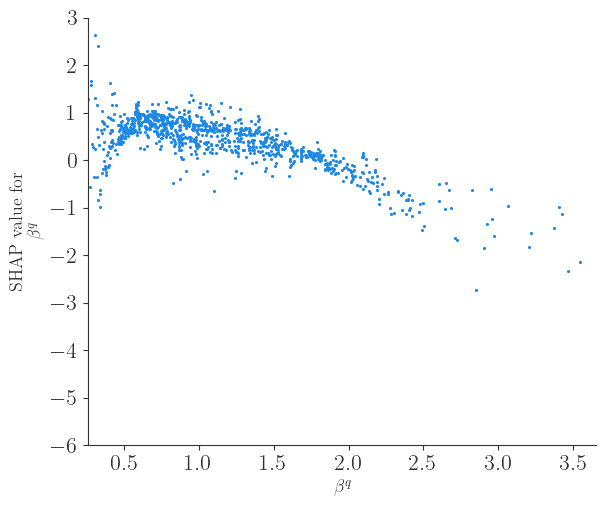

In [27]:
names = ['C', 'al', 'bl', 'aq', 'bq']
bf = d["bf"]
ranges = [[-0.08, 0.08], [-0.18, 0.07], [-0.025, 0.025], [-0.07, 0.12], [-0.6,2.8]]
for i in range(5):
    SMEFT19.ml.SHAP_param('../data/MLmodels/xgb_lh.json', '../data/samples/mlpoints.dat', i, 0)
    ax = plt.gca()
    plt.xlim([bf[i]+ranges[i][0], bf[i]+ranges[i][1]])
    #ax.set_xticks(np.linspace(ranges[i][0], ranges[i][1], 5))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout(pad=0.5)
    plt.savefig(f'../data/plots/SHAP_{names[i]}.pdf')

# Scenario III

In [2]:
d = SMEFT19.ellipse.load('../data/ellipses/rotBIII.yaml')

In [3]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=2500, early_stopping_rounds=250, n_jobs=8, learning_rate=0.15, max_depth=25)

In [31]:
ML = SMEFT19.ml.train(['../data/samples/training_III.dat'],
                 '../data/samples/validationpoints_III.dat', '../data/MLmodels/xgb_lh_rotBIII.json', d['bf'], SMEFT19.scenarios.rotBIII(), headers=0, model=model)

[0]	validation_0-rmse:14.72187
[1]	validation_0-rmse:12.58665
[2]	validation_0-rmse:10.77188
[3]	validation_0-rmse:9.24145
[4]	validation_0-rmse:7.94557
[5]	validation_0-rmse:6.83904
[6]	validation_0-rmse:5.90647
[7]	validation_0-rmse:5.11231
[8]	validation_0-rmse:4.44618
[9]	validation_0-rmse:3.88086
[10]	validation_0-rmse:3.41022
[11]	validation_0-rmse:3.01718
[12]	validation_0-rmse:2.69311
[13]	validation_0-rmse:2.41649
[14]	validation_0-rmse:2.19072
[15]	validation_0-rmse:2.00348
[16]	validation_0-rmse:1.85686
[17]	validation_0-rmse:1.73177
[18]	validation_0-rmse:1.63118
[19]	validation_0-rmse:1.55035
[20]	validation_0-rmse:1.48683
[21]	validation_0-rmse:1.43013
[22]	validation_0-rmse:1.38415
[23]	validation_0-rmse:1.34244
[24]	validation_0-rmse:1.30892
[25]	validation_0-rmse:1.28029
[26]	validation_0-rmse:1.25960
[27]	validation_0-rmse:1.24356
[28]	validation_0-rmse:1.22871
[29]	validation_0-rmse:1.21799
[30]	validation_0-rmse:1.20784
[31]	validation_0-rmse:1.19980
[32]	validation

In [4]:
ML = SMEFT19.ml.load_model('../data/MLmodels/xgb_lh_rotBIII.json', '../data/samples/validationpoints_III.dat', d['bf'], SMEFT19.scenarios.rotBIII())

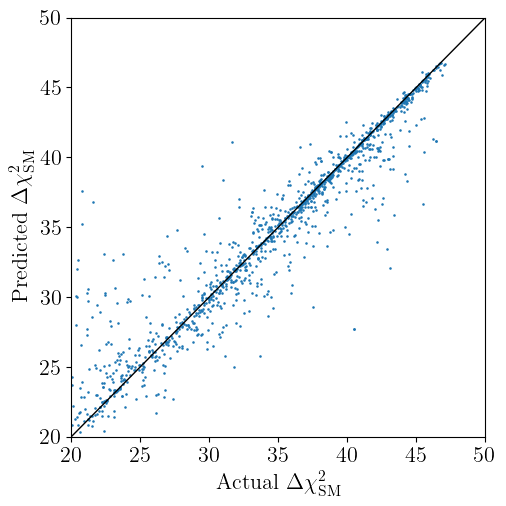

In [32]:
regres = SMEFT19.ml.regr(ML, '../data/samples/validationpoints_III.dat', '../data/plots/regression_xgb_III')

In [33]:
regres

PearsonRResult(statistic=0.9448405016513274, pvalue=0.0)

In [98]:
newpoints = []
preds = []
x0 = d['bf']
while len(preds) < 5000:
    p = np.random.multivariate_normal([0, 0, 0], np.diag([0.3**2, 0.3**2, 3**2])*1e-3)
    if p[0]+x0[0] < -0.3 or p[0]+x0[0] > 0 or p[1]+x0[1] < -0.3 or p[1]+x0[1] > 0 or p[2] + x0[2] < 0 or p[2] + x0[2] > 3:
        x0 = np.random.uniform([-0.3, -0.3, 0], [0, 0, 3])
        p = np.zeros(3)
    u = np.random.uniform()
    pred_p = float(ML.model.predict(pd.DataFrame([p+x0], columns=ML.likelihood.scenario.pars)))
    if pred_p > np.log(u) - d['L']:
        x0 = x0 + p
        newpoints.append(x0)
        preds.append(pred_p)

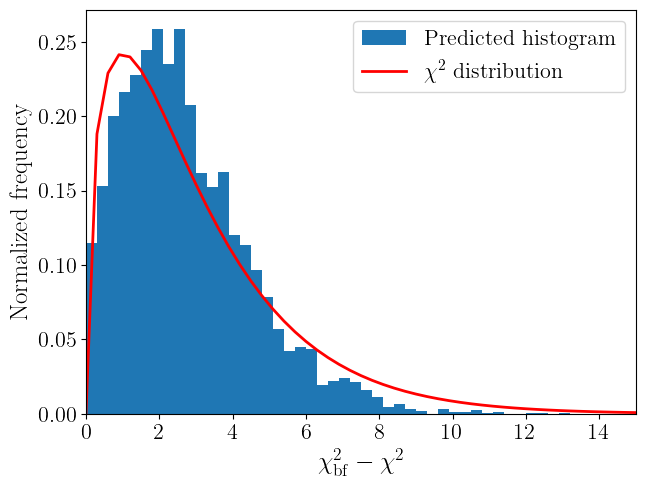

In [55]:
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

_ = plt.hist(-2*d['L'] - 2*np.array(preds), bins=50, range=(0,15), density=True, label='Predicted histogram')
plt.plot(np.linspace(0,15,51), chi2(3).pdf(np.linspace(0,15,51)), label=r'$\chi^2$ distribution', lw=2, c='r')
plt.xlim([0,15])
plt.xlabel(r'$\chi^2_\mathrm{bf} - \chi^2$', fontsize=18)
plt.ylabel('Normalized frequency', fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/hist_xgb_III.pdf')
plt.savefig('../data/plots/hist_xgb_III.pgf')

Text(0, 0.5, '$C_3$')

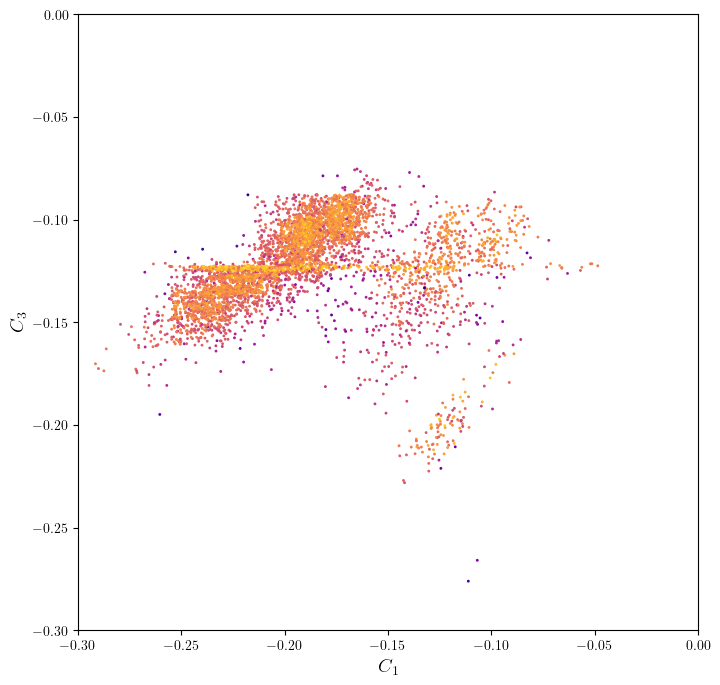

In [51]:
fig = plt.figure(figsize=(8,8))
plt.scatter([p[0] for p in newpoints], [p[1] for p in newpoints], s=1.1, c=preds, cmap='plasma')
plt.xlim([-0.3, 0])
plt.ylim([-0.3, 0])
plt.xlabel(r'$C_1$')
plt.ylabel(r'$C_3$')

Text(0, 0.5, '$\\beta^q$')

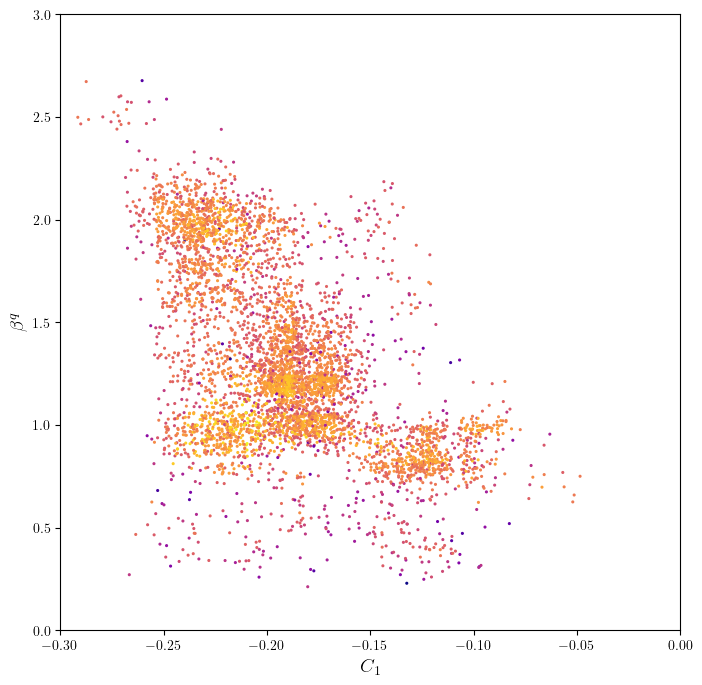

In [52]:
fig = plt.figure(figsize=(8,8))
plt.scatter([p[0] for p in newpoints], [p[2] for p in newpoints], s=1.5, c=preds, cmap='plasma')
plt.xlim([-0.3, 0])
plt.ylim([0, 3])
plt.xlabel(r'$C_1$')
plt.ylabel(r'$\beta^q$')

Text(0, 0.5, '$\\beta^q$')

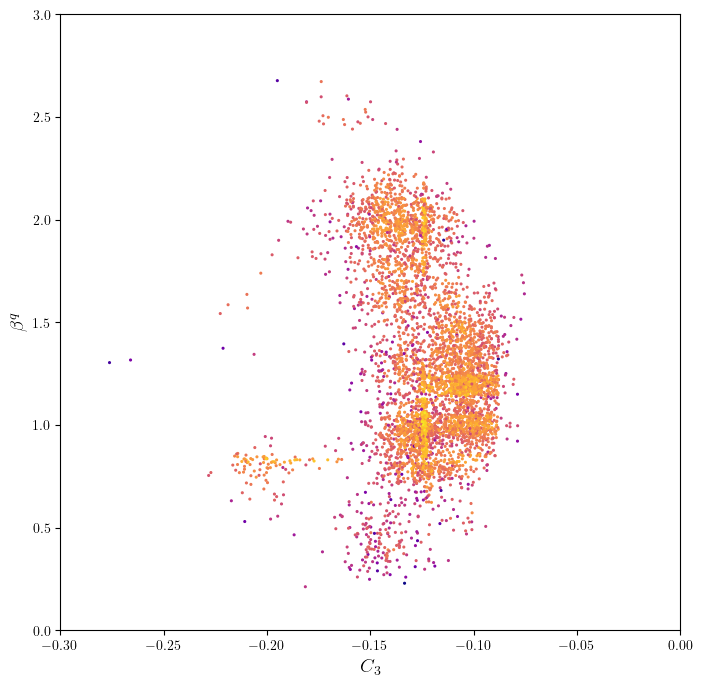

In [53]:
fig = plt.figure(figsize=(8,8))
plt.scatter([p[1] for p in newpoints], [p[2] for p in newpoints], s=1.5, c=preds, cmap='plasma')
plt.ylim([0, 3])
plt.xlim([-0.3, 0])
plt.xlabel(r'$C_3$')
plt.ylabel(r'$\beta^q$')